## Level 2

In [1]:
%pip install transformers trl

  Obtaining dependency information for trl from https://files.pythonhosted.org/packages/0d/44/c406c3cf5981bddb16ff72acb5ca235888db4073d868cf51bd143bef3aad/trl-0.7.4-py3-none-any.whl.metadata
  Obtaining dependency information for tyro>=0.5.11 from https://files.pythonhosted.org/packages/c5/11/abdf67467d06713b431618732a43f82d1b1f02120107b05a789afbcdf54d/tyro-0.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for shtab>=1.5.6 from https://files.pythonhosted.org/packages/40/ad/7227da64498eaa7abecee4311008f70869e156014b3270cec36e2e70cd31/shtab-1.6.5-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 12.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [26]:
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from dataclasses import dataclass, field
from typing import Dict, Optional

tqdm.pandas()

from transformers import (
    pipeline,
    AutoTokenizer,
    TrainingArguments,
    AutoModelForCausalLM
)

import datasets

from torch.utils.data import (
    Dataset,
    DataLoader,
    RandomSampler,
    random_split
)

import torch.nn as nn
import torch.nn.functional as F

from trl import (
    AutoModelForCausalLMWithValueHead,
    DPOTrainer,
    create_reference_model
)

from trl.core import LengthSampler

from typing import List, Dict
from scipy.stats import entropy
from collections import defaultdict

# import wandb

import pickle

import gc

In [3]:
# название SFT модели
model_name = 'lvwerra/gpt2-imdb'

# название Reward модели
reward_model_name = 'lvwerra/distilbert-imdb'

# задаем параметры оценки
sentiment_pipe_kwargs = {
    'top_k': None,
    'function_to_apply': 'none',
    'batch_size': 16
}

# задаем параметры генерации
generation_pipe_kwargs = {
    'num_return_sequences': 1,
    'min_length': 32,
    'max_length': 64,
    'top_k': 0.0,
    'top_p': 1.0,
    'do_sample': True,
}

In [4]:
def seed_all(seed: int) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

In [5]:
seed_all(42)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
import wandb

wandb.init()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Загрузим датасет, полученный на 1 этапе, и сделаем выборку на 500 примеров.

In [8]:
with open("/kaggle/input/prompt-chosen-rejected-dict-large/prompt_chosen_rejected_dict.pkl", "rb") as file:
    prompt_chosen_rejected_dict = pickle.load(file)

In [9]:
size = 500

In [10]:
train_split = {
    'prompt': prompt_chosen_rejected_dict['prompt'][: int(size*0.8)],
    'chosen': prompt_chosen_rejected_dict['chosen'][: int(size*0.8)],
    'rejected': prompt_chosen_rejected_dict['rejected'][: int(size*0.8)]
}

eval_split = {
    'prompt': prompt_chosen_rejected_dict['prompt'][int(size*0.8): int(size*0.95)],
    'chosen': prompt_chosen_rejected_dict['chosen'][int(size*0.8): int(size*0.95)],
    'rejected': prompt_chosen_rejected_dict['rejected'][int(size*0.8): int(size*0.95)]
}

test_split = {
    'prompt': prompt_chosen_rejected_dict['prompt'][int(size*0.95): size],
    'chosen': prompt_chosen_rejected_dict['chosen'][int(size*0.95): size],
    'rejected': prompt_chosen_rejected_dict['rejected'][int(size*0.95): size]
}

In [11]:
train_dataset = datasets.Dataset.from_dict(train_split)
eval_dataset = datasets.Dataset.from_dict(eval_split)
test_dataset = datasets.Dataset.from_dict(test_split)

Напишем функцию для подсчета средней оценки:

In [57]:
def mean_reward(model, tokenizer):
    bs = len(test_dataset) // 10
    game_data = dict()
    test_dataset.set_format('pandas')
    batch = test_dataset[:].sample(bs)
    game_data['prompt'] = batch['prompt'].tolist()
    query_tensors = batch['prompt'].map(tokenizer).tolist()
    output_min_length = 32
    output_max_length = 64
    output_length_sampler = LengthSampler(output_min_length, output_max_length)
    response_tensors = []

    for i in tqdm(range(bs)):
        gen_len = output_length_sampler()
        output = model.generate(
            torch.nan_to_num(torch.tensor(query_tensors[i]['input_ids']), nan=0, posinf=1, neginf=0).unsqueeze(dim=0).to(device), **generation_pipe_kwargs).squeeze()[-gen_len:]
        response_tensors.append(output)

    game_data['response'] = [tokenizer.decode(response_tensors[i]) for i in range(bs)]
    texts = [q + r for q, r in zip(game_data['prompt'], game_data['response'])]
    game_data['rewards'] = [output[0]['score'] if output[0]['label'] == 'POSITIVE' else output[1]['score'] for output in sentiment_pipe(texts,  **sentiment_pipe_kwargs)]

    df_results = pd.DataFrame(game_data)
    return df_results['rewards'].mean()

Назначем исходную функцию из DPOTrainer временной переменной, чтобы можно было ей воспользоваться в дальнейшем. 

In [13]:
dpo_trainer_loss = DPOTrainer.dpo_loss

Реализуем в классе DPOTrainerExtension недостающие лоссы из статьи.

In [46]:
class DPOTrainerExtension(DPOTrainer):
    def __init__(self, *args,  **kwargs):
        alpha = kwargs.pop('alpha') if 'alpha' in kwargs.keys() else 0
        super(DPOTrainerExtension, self).__init__(*args, **kwargs)    
        self.alpha = alpha
        
    def dpo_loss(
        self,
        policy_chosen_logps,
        policy_rejected_logps,
        reference_chosen_logps,
        reference_rejected_logps,
        reference_free: bool = False
    ):
        
        if self.loss_type == 'alpha-divergence':
            logits = torch.exp((reference_rejected_logps - policy_rejected_logps) * self.alpha) - torch.exp((reference_chosen_logps - policy_chosen_logps) * self.alpha)
            losses = -F.logsigmoid((self.beta / self.alpha) * logits)            
        elif self.loss_type == 'FKL':
            logits = torch.exp(reference_rejected_logps - policy_rejected_logps) - torch.exp(reference_chosen_logps - policy_chosen_logps)
            losses = -F.logsigmoid(self.beta * logits)
        elif self.loss_type == 'JSD':
            pi_logratios = policy_chosen_logps - policy_rejected_logps
            logits = pi_logratios - torch.logaddexp(policy_chosen_logps, reference_chosen_logps) + torch.logaddexp(policy_rejected_logps, reference_rejected_logps)
            losses = -F.logsigmoid(self.beta * logits)
        else:
            pi_logratios = policy_chosen_logps - policy_rejected_logps
            if reference_free:
                ref_logratios = 0
            else:
                ref_logratios = reference_chosen_logps - reference_rejected_logps

            logits = pi_logratios - ref_logratios
            losses, _, _ = dpo_trainer_loss(
                    self,
                    policy_chosen_logps,
                    policy_rejected_logps,
                    reference_chosen_logps,
                    reference_rejected_logps,
                    reference_free
                )
            
        chosen_rewards = self.beta * (policy_chosen_logps - reference_chosen_logps).detach()
        rejected_rewards = self.beta * (policy_rejected_logps - reference_rejected_logps).detach()
        
        return losses, chosen_rewards, rejected_rewards 

In [16]:
train_kwargs = {
    'model_name': 'lvwerra/gpt2-imdb',
    'report_to': 'wandb',
    'learning_rate': 1e-3,
    'per_device_train_batch_size': 16,
    'max_length': 512,
    'max_steps': 200,
    'gradient_accumulation_steps': 1,
    'beta': 0.1,
    'max_target_length': 128,
    'max_prompt_length': 128
}

In [17]:
training_args = TrainingArguments(
        per_device_train_batch_size=train_kwargs['per_device_train_batch_size'],
        dataloader_num_workers=4,
        max_steps=train_kwargs['max_steps'],
        remove_unused_columns=False,
        gradient_accumulation_steps=train_kwargs['gradient_accumulation_steps'],
        learning_rate=train_kwargs['learning_rate'],
        evaluation_strategy='steps',
        logging_first_step=True,
        logging_steps=50,
        eval_steps=100,
        per_device_eval_batch_size=16,
        output_dir='./test2',
        optim="rmsprop",
        warmup_steps=100,
        report_to=None,
        save_steps=train_kwargs['max_steps'],
        gradient_checkpointing=False,
    )

In [18]:
from scipy.stats import entropy
from collections import defaultdict

def token_entropy(generations, tokenizer):
    stats = defaultdict(int)
    num_tokens = 0
    for example in generations:
        tokens = tokenizer.encode(example)
        for t in tokens:
            if t == tokenizer.pad_token_id:
                continue
            stats[t] += 1
            num_tokens += 1
    for k in stats.keys():
        stats[k] /= num_tokens

    return entropy(list(stats.values()))

In [19]:
def create_test_generations(model, tokenizer):
    generator = pipeline('text-generation', model=model, device=device, tokenizer=tokenizer, **generation_pipe_kwargs)
    generated_reviews = generator(test_dataset['prompt'].to_list(), **generation_pipe_kwargs)
    generated_texts = []
    for batch_elem in tqdm(generated_reviews):
        for x in batch_elem:
            generated_texts.append(x['generated_text'])
            break
    return generated_texts

In [20]:
gpt2_model = AutoModelForCausalLM.from_pretrained(model_name)
gpt2_tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')

gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
generation_pipe_kwargs['pad_token_id'] = gpt2_tokenizer.eos_token_id

In [21]:
sentiment_pipe = pipeline(model='lvwerra/distilbert-imdb', device=device,  **sentiment_pipe_kwargs)

In [66]:
rewards_dict = dict()
entropy_dict = dict()

In [67]:
rewards_dict['sft'] = mean_reward(gpt2_model.to(device), gpt2_tokenizer)
entropy_dict['sft'] = token_entropy(create_test_generations(gpt2_model, gpt2_tokenizer), gpt2_tokenizer)

100%|██████████| 2/2 [00:01<00:00,  1.97it/s]
/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 25/25 [00:00<00:00, 90006.52it/s]


In [71]:
for loss_type in ['alpha-divergence', 'JSD', 'sigmoid', 'hinge']:
    model = AutoModelForCausalLM.from_pretrained(model_name)
    ref_model = create_reference_model(model)
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')

    tokenizer.pad_token = gpt2_tokenizer.eos_token
    generation_pipe_kwargs['pad_token_id'] = gpt2_tokenizer.eos_token_id
    
    dpo_trainer = DPOTrainerExtension(
        model,
        ref_model,
        args=training_args,
        beta=train_kwargs['beta'],
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        max_length=train_kwargs['max_length'],
        max_target_length=train_kwargs['max_target_length'],
        max_prompt_length=train_kwargs['max_prompt_length'],
        generate_during_eval=False,
        loss_type=loss_type,
        alpha=0.3
    )
    dpo_trainer.train()
    rewards_dict[loss_type] = mean_reward(model.to(device), tokenizer)
    entropy_dict[loss_type] = token_entropy(create_test_generations(model, tokenizer), tokenizer)

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen
100,2437293.280000,725530902528.000000,-2.162792,-2.104983,0.484091,-0.057809,-83.851540,-77.130470,-17.305370,-17.228334
200,10.316200,16877297336320.000000,-2.630688,-2.812903,0.509091,0.182215,-90.930740,-81.809433,-24.885086,-24.859056


100%|██████████| 2/2 [00:00<00:00,  2.64it/s]
/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 25/25 [00:00<00:00, 39390.53it/s]
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen
100,0.260800,0.858704,-16.641773,-19.406204,0.702273,2.764432,-256.863708,-221.920258,-203.695709,-203.441254
200,0.000100,0.976107,-18.489758,-21.619564,0.707955,3.129805,-278.997345,-240.400146,-223.492844,-223.225983


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]
/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 25/25 [00:00<00:00, 41560.68it/s]
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen
100,0.306300,0.880982,-12.707644,-15.166303,0.727273,2.458658,-214.464752,-182.579010,-143.139145,-143.413513
200,0.000200,0.918611,-15.250323,-18.355150,0.727273,3.104827,-246.353226,-208.005783,-181.624756,-181.473892


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]
/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 25/25 [00:00<00:00, 79497.80it/s]
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen
100,0.242800,1.048101,-18.312092,-20.902243,0.721591,2.590153,-271.824158,-238.623459,-94.945572,-94.086945
200,0.001800,1.142764,-13.213511,-15.720708,0.684091,2.507198,-220.008759,-187.637619,-92.412155,-91.277893


100%|██████████| 2/2 [00:01<00:00,  1.96it/s]
/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 25/25 [00:00<00:00, 80227.70it/s]


In [77]:
pd.DataFrame({'rewards': rewards_dict, 'entropy': entropy_dict})

,rewards,entropy
sft,-1.595453,5.432073
alpha-divergence,0.044923,4.940922
JSD,0.684693,2.243668
sigmoid,0.571607,4.114937
hinge,0.308420,4.046111


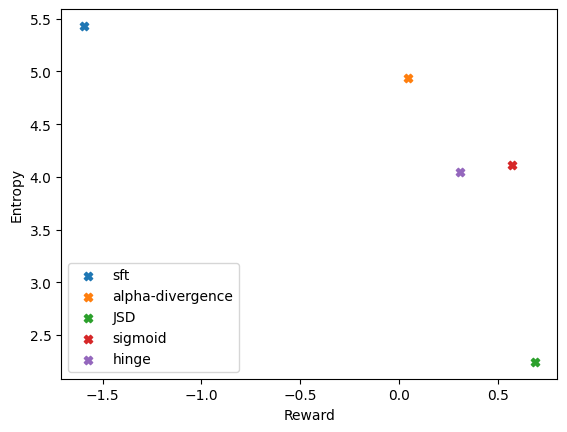

In [86]:
plt.scatter(rewards_dict['sft'], entropy_dict['sft'], marker='X')
plt.scatter(rewards_dict['alpha-divergence'], entropy_dict['alpha-divergence'], marker='X')
plt.scatter(rewards_dict['JSD'], entropy_dict['JSD'], marker='X')
plt.scatter(rewards_dict['sigmoid'], entropy_dict['sigmoid'], marker='X')
plt.scatter(rewards_dict['hinge'], entropy_dict['hinge'], marker='X')
plt.xlabel("Reward")
plt.ylabel("Entropy")
plt.legend(rewards_dict.keys())
plt.show()

### **Вывод:**  
   В ходе проведения второй части экспериментов были реализованны лоссы, предложенные авторами статьи.   
Полученные данные нанесенные на график схожи с теми, что приводятся в статье. Как можно видеть sft имеет максимальное отклонение, в то время как модель обученная с помощью JSD показала наилучшиее результаты.